# Training script

### Imports

In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from transformers import AutoTokenizer, BertModel
from datasets import load_dataset
from torch import nn
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import string
import fasttext
from sklearn.svm import SVC
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from sklearn.metrics import accuracy_score, classification_report
import pickle

import os
os.makedirs('saved_models', exist_ok=True)

model = BertModel.from_pretrained("bert-base-uncased")
embedding_matrix = model.embeddings.word_embeddings.weight
transformer_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Models

In [2]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, num_cells, hidden_size, bi, out_features):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size = input_size, num_layers = num_cells, hidden_size = hidden_size, bidirectional=bi, batch_first = True)
        self.batch_norm = nn.BatchNorm1d(num_features = hidden_size * 2 if bi else hidden_size)
        self.dropout = nn.Dropout(p = 0.2)
        self.relu1 = nn.ReLU()
        self.linear1 = nn.Linear(in_features = hidden_size * 2 if bi else hidden_size, out_features = out_features)
        #self.relu2 = nn.ReLU()
        #self.linear2 = nn.Linear(in_features = 100, out_features = out_features)
        
        # with torch.no_grad():
            # self.linear1.bias.fill_(-torch.log(torch.tensor(out_features - 1)))
            # self.linear2.bias.fill_(-torch.log(torch.tensor(out_features - 1)))
    
    def forward(self, embedding_sequence):
        # Pad first sequence to max length
        # embedding_sequence[0] = torch.concat([embedding_sequence[0], torch.zeros((self.max_sequence_length - embedding_sequence[0].shape[0] ,self.input_size)).cuda()])
        # Get lenghts vector for every embeddings sequence to later use for packing
        lengths = torch.Tensor([embedding.shape[0] for embedding in embedding_sequence]).long()
        # Pad sequence
        padded_sequence = pad_sequence(embedding_sequence)
        # Pack sequence
        packed_sequence = pack_padded_sequence(padded_sequence, lengths = lengths, enforce_sorted = False)
        # print(padded_sequence.shape)
        
        packed_out, _ = self.lstm(packed_sequence)
        padded_out, _ = pad_packed_sequence(packed_out)
    
        # print(padded_out.shape)
    
        out_forward = padded_out[lengths - 1, range(padded_out.shape[1]), :self.hidden_size]
        out_reverse = padded_out[0, :, self.hidden_size:]
        
        # print(out_forward.shape)
        # print(out_reverse.shape)
        
        out = torch.cat([out_forward, out_reverse], dim = 1)
        
        # print(out.shape)
        
        x = self.batch_norm(out)
        x = self.dropout(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.linear1(x)
        #x = self.relu2(x)
        #x = self.linear2(x)
        return x

In [3]:
# model = MLP(37).cuda() # Replace model instantiation with another class here (SVC for example) if wishing to test other models
# model = XGBClassifier(n_estimators = 300, max_depth = 13, learning_rate = 0.01)
# model = XGBClassifier(n_estimators = 100, max_depth = 39 * 2, learning_rate = 0.01)
# model = SVC(C = 1, kernel = 'rbf', gamma = 'scale')
# TODO: somehting is wrong since the dict-based model achieves 0.30 accuracy
# and it only encounters 30/3000 not previously seen examples in the test set
# so it should have a 0.99 accuracy


nr_features = 768
batch_size = 32
learning_rate = 2e-5
epochs = 10
patience = 2
class_weight_beta = 0.999

In [4]:
def process_intent_list(intent_list):
    intents = set()
    if len(intent_list) == 0:
        intents.add('other')
    for intent in intent_list:
        if intent.startswith('Restaurant'):
            intents.add(intent)
        elif intent.startswith('Hotel'):
            intents.add(intent)
        elif intent.startswith('Booking'):
            intents.add(intent)
        elif intent.startswith('general'):
            intents.add(intent)
        else:
            intents.add('other')
    # print(f'Original {intent_list}')
    # print(f'Modified {list(intents)}')
    return list(intents)

def process_service_list(service_list):
    services = set()
    if len(service_list) == 0:
        services.add('other')
    for service in service_list:
        if service == 'restaurant':
            services.add('restaurant')
        elif service == 'hotel':
            services.add('hotel')
        else:
            services.add('other')
        if len(services) == 3:
            break
    return list(services)

### Loading the dataset

In [5]:
def preprocess_split(dataset, split):
    df = dataset[split].to_pandas()
    new_df = pd.DataFrame(columns = df.columns)
    for i in range(len(df)):
        # Taken from notebook, to know which lines to skip
        row = df.loc[i]
        if not any(set(row.turns['frames'][turn_id]['service']).intersection(['hotel', 'restaurant']) for turn_id,utt in enumerate(row.turns['utterance'])):
            continue
        
        new_df.loc[len(new_df)] = row
        # new_df.loc[len(new_df) - 1]['services'] = process_service_list(new_df.loc[len(new_df) - 1]['services'])
        # for i, frame_service in [frame['service'] for frame in df.loc[i].turns['frames']]:
            # df.loc[i].turns['frames']
    return new_df

def extract_to_be_retrieved_info(dataset):
    user_act_types_list = []
    user_slots_per_act_type_list = []
    to_be_retrieved_list = []
    embeddings_list = []
    agent_act_types_list = []
    
    nr = 0
    for i in tqdm(range(len(dataset))):
        turns = dataset.loc[i].turns
        for j, (utterance, speaker, dialogue_act, frames) in enumerate(zip(turns['utterance'], turns['speaker'], turns['dialogue_acts'], turns['frames'])):
            # if speaker != 1:
                # continue
            # Skip using dialogue act intents
            # print(dialogue_act['dialog_act']['act_type'])
            # if 'other' in process_intent_list(dialogue_act['dialog_act']['act_type']):
                # continue
            # Skip using frame services
            # if 'other' in process_service_list(frames['service']):
                # continue
            services = frames['service']
            if speaker == 0:
                current_booking_service = [service for service in services if service in ["hotel", "restaurant"]]
                
            act_types = dialogue_act['dialog_act']['act_type']
            act_slots = dialogue_act['dialog_act']['act_slots']
            
            # if speaker == 1 and not any(act_type.startswith("Hotel") or act_type.startswith("Restaurant") or act_type.startswith("Booking") for act_type in act_types):
            #     user_act_types_list.pop()
            #     user_slots_per_act_type_list.pop()
            #     continue
            
            # print(act_types)
            if speaker == 0:
                if len([1 for act_type in dialogue_act['dialog_act']['act_type'] if act_type.startswith('general')]) == len(dialogue_act['dialog_act']['act_type']):
                    skip_bot = True
                    continue
                
                if 'other' in process_intent_list(dialogue_act['dialog_act']['act_type']):
                    skip_bot = True
                    continue
                if 'other' in process_intent_list(turns['dialogue_acts'][j + 1]['dialog_act']['act_type']):
                    skip_bot = True
                    continue
                skip_bot = False
            else:
                if skip_bot:
                    continue
            
            # print(act_slots)
            # print(act_types)
            slots_per_act_type = []
            to_be_retrieved = set()
            for act_type, slots in zip(act_types, act_slots):
                slot_names = slots['slot_name']
                slot_values = slots['slot_value']
                
                domain = act_type.split('-')[0].lower()
                if domain == 'booking' and len(current_booking_service)==1:
                    domain = current_booking_service[0]
                
                # if 'hotel' in domain or 'restaurant' in domain:
                if speaker == 0: # When it's the user's turn
                    for slot_name, slot_value in zip(slot_names, slot_values):
                        if slot_name != 'none':
                            slots_per_act_type.append(act_type.lower() + '-' + slot_name + ':' + slot_value)
                else: # When it's the bot's turn
                    act_type_relevant_slots = [(slot_name, slot_value) for slot_name, slot_value in zip(slot_names, slot_values) if slot_value != '?' and 'choice' not in slot_name and slot_name != 'none']
                    to_be_retrieved.update(set([domain + '-' + slot_name for slot_name, _ in act_type_relevant_slots]))
                    
                    if len(to_be_retrieved) != 0 and any((slot_name_value.split(":")[0]!=domain+"-none" for slot_name_value in to_be_retrieved)) and not "-No" in act_types:
                        to_be_retrieved.add(domain + '-availability-yes')
                    elif "-No" in act_types:
                        to_be_retrieved.add(domain + '-availability-no')
                
            if speaker == 0: # When it's the user's turn
                user_act_types_list.append(act_types)
                user_slots_per_act_type_list.append(slots_per_act_type)
                
                # nr += 1
                # print(nr)
                # print("Input:", slots_per_act_type)
            else: # When it's the bot's turn
                to_be_retrieved_list.append(list(to_be_retrieved))
                agent_act_types_list.append(act_types)
                
                print(act_types)
                
                user_slots_per_act_type = user_slots_per_act_type_list[-1]
                to_be_retrieved = to_be_retrieved_list[-1]
                
                input_text = ', '.join(user_slots_per_act_type) + ' | ' + ', '.join(to_be_retrieved)
                print(input_text)
                
                tokenized_seen_slots = transformer_tokenizer(input_text)
                with torch.no_grad():
                    embedding = embedding_matrix[tokenized_seen_slots.input_ids].detach().numpy()
                embeddings_list.append(embedding)
            
    return embeddings_list, agent_act_types_list

In [6]:
dataset = load_dataset('multi_woz_v22')

try:
    train
    print("Dataset already loaded, moving on")
except:
    train = preprocess_split(dataset, 'train')
    test = preprocess_split(dataset, 'test')
    val = preprocess_split(dataset, 'validation')
    train_embeddings_list, train_agent_act_types_list = extract_to_be_retrieved_info(train)
    test_embeddings_list, test_agent_act_types_list = extract_to_be_retrieved_info(test)
    val_embeddings_list, val_agent_act_types_list = extract_to_be_retrieved_info(val)

No config specified, defaulting to: multi_woz_v22/v2.2_active_only
Found cached dataset multi_woz_v22 (/home/adrian/.cache/huggingface/datasets/multi_woz_v22/v2.2_active_only/2.2.0/6719c8b21478299411a0c6fdb7137c3ebab2e6425129af831687fb7851c69eb5)


  0%|          | 0/3 [00:00<?, ?it/s]

  1%|▏         | 94/6321 [00:00<00:06, 933.82it/s]

['Restaurant-Inform' 'Restaurant-Select']
restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | restaurant-availability-yes, restaurant-food
['Restaurant-Inform']
restaurant-request-food:? | restaurant-availability-yes, restaurant-area, restaurant-food, restaurant-name
['Hotel-Recommend' 'Restaurant-Inform']
hotel-inform-pricerange:expensive, hotel-inform-type:hotel, restaurant-request-phone:? | hotel-area, restaurant-phone, hotel-name, hotel-availability-yes, restaurant-availability-yes, restaurant-name
['Booking-Request']
 | 
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:saturday, hotel-inform-bookpeople:2, hotel-inform-bookstay:2 | hotel-ref, general-availability-yes, hotel-availability-yes
['Hotel-Inform' 'Hotel-Select']
hotel-inform-internet:yes, hotel-inform-parking:yes | hotel-availability-yes, hotel-type, hotel-pricerange
['Hotel-Request' 'Restaurant-Request']
hotel-inform-area:south | 
['Booking-Inform' 'Hotel-Inform' 'Restaurant-Recommend']
hotel-i

  4%|▍         | 282/6321 [00:00<00:06, 913.51it/s]

['Hotel-Recommend' 'general-reqmore']
hotel-inform-area:west, hotel-inform-pricerange:cheap | hotel-name, hotel-availability-yes, general-availability-yes
['Booking-Inform' 'Hotel-Inform']
hotel-request-parking:? | hotel-name, hotel-parking, hotel-availability-yes
['Hotel-Inform' 'Hotel-Request']
hotel-inform-stars:4, hotel-inform-type:guesthouse | hotel-availability-yes, hotel-stars
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:saturday, hotel-inform-bookpeople:5, hotel-inform-bookstay:3 | hotel-ref, general-availability-yes, hotel-availability-yes
['Hotel-Inform' 'general-greet']
hotel-inform-area:north, hotel-inform-parking:yes | hotel-pricerange, hotel-availability-yes, hotel-stars, general-availability-yes, hotel-name
['Booking-Inform' 'Hotel-Inform']
hotel-inform-pricerange:expensive, hotel-inform-stars:3 | hotel-name, hotel-availability-yes
['Hotel-Inform']
hotel-inform-internet:dontcare, hotel-inform-parking:yes | hotel-name, hotel-area, hotel-availability-yes, hotel-

  7%|▋         | 460/6321 [00:00<00:07, 832.87it/s]

['general-bye' 'general-greet']
hotel-request-name:? | 
['Restaurant-Request']
restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | 
['Booking-Book' 'Restaurant-Inform' 'general-reqmore']
restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:5, restaurant-inform-booktime:12:00, restaurant-inform-food:dontcare | restaurant-bookday, general-availability-yes, restaurant-address, restaurant-availability-yes, restaurant-name, restaurant-booktime, restaurant-bookpeople, restaurant-food, restaurant-ref
['Hotel-Inform' 'Hotel-Request' 'Hotel-Select']
hotel-inform-area:north, hotel-inform-parking:yes | hotel-availability-yes, hotel-type
['Booking-Inform' 'Hotel-Inform' 'Hotel-Select']
hotel-inform-type:hotel | hotel-name, hotel-availability-yes
['Hotel-Inform' 'Hotel-Recommend']
hotel-inform-area:north, hotel-inform-parking:yes, hotel-inform-type:guesthouse | hotel-pricerange, hotel-name, hotel-availability-yes, hotel-type, hotel-stars
['Booking-NoBook' 'Booking-R

 10%|▉         | 628/6321 [00:00<00:06, 817.69it/s]

hotel-inform-pricerange:cheap | hotel-availability-yes, hotel-type
['Booking-Inform' 'Hotel-Inform']
hotel-inform-bookday:wednesday, hotel-inform-bookpeople:6, hotel-inform-bookstay:3, hotel-inform-pricerange:cheap | hotel-name, hotel-parking, hotel-pricerange, hotel-availability-yes
['Booking-NoBook' 'general-reqmore']
hotel-inform-bookstay:3 | 
['Booking-Book']
 | hotel-name, hotel-ref, hotel-availability-yes
['Restaurant-NoOffer' 'Restaurant-Request']
restaurant-inform-area:centre, restaurant-inform-food:mexican | restaurant-availability-yes, restaurant-area, restaurant-food
['Restaurant-Inform']
restaurant-inform-food:indian | restaurant-availability-yes, restaurant-food, restaurant-name
['Booking-NoBook' 'Booking-Request']
restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:18:00 | restaurant-availability-yes, restaurant-booktime, restaurant-bookday
['Booking-Book' 'general-reqmore']
restaurant-inform-booktime:17:00 | restaurant-availabilit

 13%|█▎        | 796/6321 [00:00<00:06, 813.66it/s]

['Booking-Book']
hotel-inform-bookday:wednesday, hotel-inform-bookpeople:3, hotel-inform-bookstay:2 | hotel-ref, hotel-availability-yes
['Restaurant-NoOffer' 'general-reqmore']
restaurant-inform-food:steakhouse, restaurant-inform-pricerange:expensive | 
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-food:british | restaurant-pricerange, restaurant-availability-yes, restaurant-food
['Restaurant-Inform']
restaurant-inform-area:dontcare | restaurant-area, restaurant-food, restaurant-pricerange, restaurant-availability-yes, restaurant-name
['Restaurant-Inform' 'general-reqmore']
restaurant-request-phone:? | general-availability-yes, restaurant-availability-yes, restaurant-phone
['Restaurant-Inform' 'general-reqmore']
restaurant-request-name:? | restaurant-availability-yes, general-availability-yes, restaurant-address, restaurant-name
['Booking-Inform']
restaurant-inform-name:cote | restaurant-availability-yes, restaurant-name
['Booking-NoBook' 'general-reqmore']
restaurant-in

 15%|█▌        | 964/6321 [00:01<00:06, 822.80it/s]

['Restaurant-Request']
restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | 
['Booking-Book' 'Restaurant-Inform']
restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:16:00 | booking-ref, restaurant-food, booking-availability-yes, booking-name, restaurant-availability-yes
['Booking-Inform' 'Hotel-Inform']
hotel-inform-pricerange:cheap, hotel-inform-type:guesthouse | hotel-area, hotel-parking, hotel-internet, hotel-name, hotel-availability-yes, hotel-stars
['Booking-Request']
hotel-inform-pricerange:cheap | 
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:wednesday, hotel-inform-bookstay:3 | hotel-name, hotel-ref, general-availability-yes, hotel-availability-yes
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-name:charlie chan | restaurant-area, restaurant-food, restaurant-pricerange, restaurant-availability-yes, restaurant-name
['Booking-Book']
restaurant-inform-bookday:monday, restaurant-inform-bookpeople:2

 18%|█▊        | 1132/6321 [00:01<00:06, 811.08it/s]

hotel-inform-parking:yes, hotel-inform-type:hotel | hotel-address, hotel-availability-yes, hotel-postcode, hotel-name
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:tuesday, hotel-inform-bookpeople:8, hotel-inform-bookstay:3, hotel-inform-stars:3, hotel-request-ref:? | hotel-ref, general-availability-yes, hotel-availability-yes, hotel-bookday
['Restaurant-Recommend']
restaurant-inform-food:asian oriental | restaurant-availability-yes, restaurant-name
['Booking-Book' 'general-greet']
restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:4, restaurant-inform-booktime:18:45 | general-availability-yes, restaurant-availability-yes, restaurant-ref
['Restaurant-Inform']
restaurant-inform-food:chinese, restaurant-inform-pricerange:moderate | restaurant-availability-yes, restaurant-pricerange, restaurant-area, restaurant-name
['Restaurant-Inform' 'general-reqmore']
restaurant-request-address:?, restaurant-request-postcode:? | restaurant-postcode, general-availability-yes, r

 21%|██        | 1302/6321 [00:01<00:06, 820.37it/s]

['Restaurant-Inform' 'general-reqmore']
restaurant-inform-name:bangkok city | general-availability-yes, restaurant-availability-yes, restaurant-phone
['Restaurant-Request']
 | 
['Restaurant-Request']
restaurant-inform-food:chinese | 
['Hotel-Inform' 'Hotel-Select']
hotel-inform-area:west, hotel-inform-pricerange:cheap | hotel-availability-yes, hotel-type
['Hotel-Inform' 'Hotel-Select']
hotel-inform-parking:yes | hotel-parking, hotel-type, hotel-availability-yes
['Booking-Request' 'Hotel-Inform']
hotel-inform-internet:yes | hotel-name, hotel-availability-yes
['Booking-Inform' 'Hotel-Inform']
 | hotel-name, hotel-availability-yes, hotel-stars
['Restaurant-Inform' 'Restaurant-Select']
restaurant-inform-name:pizza hut | restaurant-availability-yes, restaurant-address, restaurant-name
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-name:fen ditton, restaurant-request-address:?, restaurant-request-food:?, restaurant-request-pricerange:? | restaurant-food, restaurant-pricerange, rest

 23%|██▎       | 1472/6321 [00:01<00:05, 815.03it/s]

['Hotel-Inform' 'Hotel-Request']
hotel-inform-parking:yes, hotel-inform-stars:3 | hotel-parking, hotel-type, hotel-stars, hotel-availability-yes
['Booking-Inform' 'Hotel-Inform']
hotel-inform-area:west | hotel-address, hotel-availability-yes, hotel-name
['Booking-Request']
hotel-request-address:? | 
['Booking-Request' 'Hotel-Inform']
hotel-inform-bookday:sunday, hotel-inform-bookpeople:2, hotel-inform-bookstay:7 | hotel-address, hotel-availability-yes
['Hotel-Inform' 'general-reqmore']
hotel-request-type:? | hotel-availability-yes, general-availability-yes, hotel-type
['Restaurant-NoOffer' 'Restaurant-Request']
restaurant-inform-area:west, restaurant-inform-food:international | restaurant-availability-yes, restaurant-food
['Booking-Inform' 'Restaurant-Inform' 'general-reqmore']
restaurant-inform-food:thai | general-availability-yes, restaurant-availability-yes, restaurant-name
['Restaurant-Inform' 'general-reqmore']
restaurant-request-address:?, restaurant-request-postcode:? | restaura

 26%|██▌       | 1638/6321 [00:01<00:05, 806.53it/s]

['Restaurant-Inform' 'Restaurant-Select']
restaurant-inform-pricerange:moderate | restaurant-pricerange, restaurant-availability-yes, restaurant-name
['Restaurant-Inform']
restaurant-inform-name:riverside brasserie | restaurant-availability-yes, restaurant-address, restaurant-phone
['Hotel-Select']
hotel-inform-pricerange:expensive, hotel-inform-stars:4 | hotel-area, hotel-availability-yes
['Hotel-Select']
hotel-inform-area:dontcare, hotel-inform-type:hotel | hotel-name, hotel-availability-yes
['Hotel-Inform']
hotel-inform-internet:yes | hotel-address, hotel-availability-yes, hotel-internet
['Booking-Request']
hotel-inform-bookstay:5, hotel-inform-name:university arms | 
['Booking-Book']
hotel-inform-bookpeople:2, hotel-inform-bookstay:5 | hotel-ref, hotel-availability-yes
['Restaurant-Request']
 | 
['Restaurant-Select']
restaurant-inform-area:north, restaurant-inform-pricerange:expensive | restaurant-availability-yes, restaurant-food
['Booking-Inform' 'Restaurant-Recommend']
restauran

 27%|██▋       | 1719/6321 [00:02<00:06, 766.08it/s]

hotel-inform-area:north, hotel-inform-pricerange:expensive | hotel-area, hotel-type, hotel-pricerange, hotel-availability-yes
['Booking-Inform' 'Hotel-Inform']
hotel-inform-area:east | 
['Booking-NoBook' 'Booking-Request']
hotel-inform-bookday:thursday, hotel-inform-bookpeople:1, hotel-inform-bookstay:4 | 
['Booking-Book']
hotel-inform-bookstay:1 | hotel-bookpeople, hotel-availability-yes, hotel-ref, hotel-bookday, hotel-name
['Restaurant-NoOffer' 'general-reqmore']
restaurant-inform-food:greek, restaurant-inform-pricerange:cheap | 
['Restaurant-Inform' 'Restaurant-Request' 'Restaurant-Select']
restaurant-inform-food:italian, restaurant-request-address:?, restaurant-request-phone:? | restaurant-area, restaurant-pricerange, restaurant-availability-yes, restaurant-food
['Restaurant-Recommend']
restaurant-inform-area:dontcare | restaurant-phone, restaurant-availability-yes, restaurant-address, restaurant-name
['Restaurant-Inform' 'general-reqmore']
restaurant-inform-area:south, restaurant

 30%|██▉       | 1873/6321 [00:02<00:05, 742.61it/s]

hotel-inform-internet:yes, hotel-inform-parking:yes | hotel-name, hotel-availability-yes
['Hotel-Inform']
hotel-inform-area:south | hotel-name, hotel-area, hotel-availability-yes
['Hotel-Inform']
hotel-request-address:?, hotel-request-phone:?, hotel-request-postcode:? | hotel-address, hotel-availability-yes, hotel-postcode, hotel-phone
['Hotel-Request']
hotel-inform-internet:yes, hotel-inform-parking:yes | 
['Hotel-Inform' 'Hotel-Request']
hotel-inform-pricerange:expensive | 
['Hotel-Inform' 'Hotel-Request']
hotel-inform-stars:dontcare | 
['Booking-Inform' 'Hotel-Recommend']
hotel-request-name:? | hotel-name, hotel-area, hotel-pricerange, hotel-availability-yes
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:sunday, hotel-inform-bookpeople:8, hotel-inform-bookstay:4 | hotel-bookstay, hotel-ref, general-availability-yes, hotel-bookpeople, hotel-bookday, hotel-name, hotel-availability-yes
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-food:international | restaurant-are

 32%|███▏      | 2021/6321 [00:02<00:06, 711.87it/s]

restaurant-inform-area:east, restaurant-inform-pricerange:expensive | 
['Restaurant-Inform']
restaurant-inform-food:dontcare | restaurant-availability-yes, restaurant-area, restaurant-food, restaurant-name
['Restaurant-Inform']
restaurant-request-address:?, restaurant-request-postcode:? | restaurant-availability-yes, restaurant-address
['Booking-Inform' 'Hotel-Inform']
hotel-inform-area:centre, hotel-inform-parking:no | hotel-name, hotel-availability-yes, hotel-pricerange
['Hotel-Inform']
hotel-inform-name:cityroomz | hotel-parking, hotel-address, hotel-internet, hotel-pricerange, hotel-name, hotel-availability-yes, hotel-stars
['Booking-Book']
hotel-inform-bookday:sunday, hotel-inform-bookpeople:5, hotel-inform-bookstay:5 | hotel-ref, hotel-availability-yes
['Hotel-Inform']
hotel-inform-area:east, hotel-inform-parking:yes, hotel-inform-type:hotel | hotel-name, hotel-area, hotel-pricerange, hotel-availability-yes
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:friday, hotel-inf

 35%|███▍      | 2187/6321 [00:02<00:05, 760.80it/s]


['Booking-Inform' 'Hotel-Inform']
hotel-request-parking:? | hotel-parking, hotel-availability-yes
['Booking-Inform']
hotel-inform-name:worth house | 
['Booking-Book']
hotel-inform-bookday:thursday, hotel-inform-bookpeople:2, hotel-inform-bookstay:3 | hotel-ref, hotel-availability-yes
['general-reqmore']
 | 
['Booking-Inform' 'Hotel-Inform']
hotel-inform-internet:no, hotel-inform-stars:3 | hotel-area, hotel-availability-yes, hotel-type, hotel-stars, hotel-address
['Booking-Request']
hotel-inform-type:hotel | 
['Hotel-Inform' 'general-reqmore']
hotel-request-postcode:? | hotel-availability-yes, hotel-postcode, general-availability-yes
['Booking-Book']
restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:18:00, restaurant-inform-name:pizza hut city centre, restaurant-request-ref:? | restaurant-availability-yes, restaurant-ref
['Hotel-Request']
hotel-inform-internet:yes, hotel-inform-pricerange:cheap | 
['Booking-Inform' 'Hotel-Inform']
hotel-inf

 37%|███▋      | 2350/6321 [00:02<00:05, 770.32it/s]

['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-food:chinese | 
['Booking-Inform' 'Restaurant-Inform' 'Restaurant-Recommend']
restaurant-inform-area:dontcare, restaurant-inform-food:european | restaurant-area, restaurant-availability-yes, restaurant-food, restaurant-name
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:friday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:14:15 | restaurant-booktime, restaurant-bookpeople, restaurant-bookday, general-availability-yes, restaurant-ref, restaurant-availability-yes
['Restaurant-Inform' 'Restaurant-Recommend']
restaurant-inform-area:west, restaurant-inform-food:indian | restaurant-availability-yes, restaurant-name
['Booking-Inform' 'Restaurant-Inform']
restaurant-request-pricerange:? | restaurant-availability-yes, restaurant-pricerange, restaurant-area
['Restaurant-Inform' 'general-reqmore']
restaurant-request-address:?, restaurant-request-postcode:? | restaurant-postcode, general-availability-yes, rest

 40%|███▉      | 2510/6321 [00:03<00:04, 783.24it/s]

['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-area:east, restaurant-inform-food:gastropub | restaurant-availability-yes, restaurant-name
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:friday, restaurant-inform-bookpeople:4, restaurant-inform-booktime:14:45 | general-availability-yes, restaurant-availability-yes, restaurant-ref
['Restaurant-Request']
restaurant-inform-area:south, restaurant-inform-pricerange:expensive, restaurant-request-address:? | 
['Restaurant-Inform' 'general-reqmore']
restaurant-inform-food:dontcare | restaurant-availability-yes, general-availability-yes, restaurant-pricerange, restaurant-address, restaurant-area, restaurant-food, restaurant-name
['Hotel-Inform']
hotel-inform-area:north, hotel-inform-type:guesthouse | hotel-area, hotel-type, hotel-availability-yes
['Hotel-Inform']
hotel-inform-pricerange:moderate | 
['Hotel-Recommend']
hotel-request-name:? | hotel-name, hotel-availability-yes, hotel-stars
['Booking-Book' 'general-reqmore']


 42%|████▏     | 2672/6321 [00:03<00:04, 784.98it/s]

['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-pricerange:moderate | restaurant-availability-yes, restaurant-pricerange, restaurant-area, restaurant-food
['Hotel-Inform' 'Hotel-Request']
hotel-inform-parking:yes, hotel-inform-pricerange:cheap | 
['Hotel-Inform' 'Hotel-Select']
hotel-inform-area:centre | hotel-name, hotel-availability-yes, hotel-type
['Hotel-Inform']
hotel-inform-internet:yes | 
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:wednesday, hotel-inform-bookpeople:2, hotel-inform-bookstay:2 | hotel-bookstay, hotel-ref, general-availability-yes, hotel-bookpeople, hotel-bookday, hotel-name, hotel-availability-yes
['Booking-Book' 'general-greet']
hotel-inform-bookpeople:3, hotel-inform-bookstay:2 | hotel-ref, general-availability-yes, hotel-availability-yes
['Restaurant-Request' 'general-greet']
restaurant-inform-area:centre | 
['Restaurant-Inform' 'Restaurant-Recommend' 'general-reqmore']
restaurant-inform-food:chinese | general-availability-yes, restaur

 45%|████▍     | 2835/6321 [00:03<00:04, 772.04it/s]

['Booking-Request']
restaurant-inform-area:south | 
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:thursday | general-availability-yes, restaurant-availability-yes, restaurant-ref
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-area:south, restaurant-inform-pricerange:expensive | 
['Booking-Inform' 'Restaurant-Inform']
restaurant-request-address:?, restaurant-request-postcode:? | restaurant-phone, restaurant-postcode, restaurant-address, restaurant-availability-yes, restaurant-name
['Restaurant-Inform' 'Restaurant-Select']
restaurant-inform-food:thai, restaurant-inform-pricerange:expensive, restaurant-request-address:?, restaurant-request-phone:? | restaurant-area, restaurant-availability-yes, restaurant-food
['Restaurant-Inform' 'general-reqmore']
restaurant-inform-area:dontcare | restaurant-area, restaurant-food, general-availability-yes, restaurant-pricerange, restaurant-availability-yes, restaurant-name
['Restaurant-Inform' 'general-reqmore']
restaurant-r

 47%|████▋     | 2999/6321 [00:03<00:04, 793.53it/s]

hotel-inform-stars:4 | hotel-internet, hotel-parking, hotel-name, hotel-availability-yes
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:friday, hotel-inform-bookpeople:3, hotel-inform-bookstay:4, hotel-inform-stars:4 | hotel-bookstay, hotel-bookpeople, hotel-availability-yes, hotel-ref, general-availability-yes, hotel-bookday
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-name:lan hong house | restaurant-area, restaurant-food, restaurant-pricerange, restaurant-availability-yes, restaurant-name
['Booking-Book']
restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:20:00, restaurant-request-ref:? | restaurant-availability-yes, restaurant-ref
['Hotel-Select']
hotel-inform-area:south, hotel-inform-stars:3 | hotel-internet, hotel-parking, hotel-type, hotel-availability-yes
['Booking-Inform' 'general-reqmore']
hotel-inform-type:guesthouse | 
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:friday, hotel-inform-bookpeople:3, h

 50%|█████     | 3167/6321 [00:03<00:03, 805.22it/s]

['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-area:east | restaurant-availability-yes, restaurant-name
['Restaurant-Inform' 'general-reqmore']
restaurant-request-phone:? | restaurant-phone, general-availability-yes, restaurant-availability-yes, restaurant-name
['Restaurant-NoOffer' 'general-reqmore']
restaurant-inform-food:creative, restaurant-inform-pricerange:moderate | 
['Restaurant-Inform']
restaurant-inform-food:european | restaurant-pricerange, restaurant-availability-yes, restaurant-food, restaurant-name
['Restaurant-Inform']
restaurant-request-address:?, restaurant-request-postcode:? | restaurant-postcode, restaurant-availability-yes, restaurant-address
['Hotel-Inform' 'general-reqmore']
hotel-inform-name:home from home | hotel-area, hotel-pricerange, hotel-availability-yes, general-availability-yes, hotel-name
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:thursday, hotel-inform-bookpeople:8, hotel-inform-bookstay:4 | booking-ref, booking-bookpeople, bookin

 53%|█████▎    | 3335/6321 [00:04<00:03, 821.24it/s]

['Restaurant-Request']
restaurant-inform-area:centre | 
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-pricerange:moderate | restaurant-availability-yes, restaurant-name
['Booking-Book']
restaurant-inform-bookday:monday, restaurant-inform-bookpeople:5, restaurant-inform-booktime:19:45 | restaurant-availability-yes, restaurant-ref
['Restaurant-Inform']
restaurant-inform-area:east, restaurant-inform-pricerange:cheap | restaurant-availability-yes, restaurant-pricerange, restaurant-area, restaurant-name
['Restaurant-Inform']
restaurant-request-address:?, restaurant-request-phone:? | restaurant-availability-yes, restaurant-address, restaurant-phone
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-food:french | restaurant-availability-yes, restaurant-name
['Booking-Request']
restaurant-inform-name:cote | 
['Restaurant-Inform' 'general-reqmore']
restaurant-inform-pricerange:moderate | general-availability-yes, restaurant-pricerange, restaurant-availability-yes
['Restaurant-I

 55%|█████▌    | 3497/6321 [00:04<00:03, 748.83it/s]

['Hotel-Inform']
 | hotel-availability-yes, hotel-type, hotel-pricerange
['Booking-Inform' 'Restaurant-Inform']
restaurant-request-area:? | restaurant-availability-yes, restaurant-area
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-pricerange:expensive | restaurant-availability-yes, restaurant-pricerange, restaurant-area
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-area:centre, restaurant-inform-food:gastropub | restaurant-area, restaurant-food, restaurant-pricerange, restaurant-availability-yes, restaurant-name
['Restaurant-Inform' 'general-reqmore']
 | restaurant-phone, restaurant-area, general-availability-yes, restaurant-address, restaurant-availability-yes, restaurant-name
['Restaurant-Request' 'general-reqmore']
restaurant-inform-food:indian, restaurant-inform-pricerange:cheap | 
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:friday, restaurant-inform-bookpeople:5, restaurant-inform-booktime:14:45 | general-availability-yes, restaurant-book

 58%|█████▊    | 3653/6321 [00:04<00:03, 743.94it/s]

['Hotel-Inform']
hotel-inform-name:alpha-milton guest house | hotel-name, hotel-area, hotel-pricerange, hotel-availability-yes
['Booking-NoBook' 'general-reqmore']
hotel-inform-bookday:thursday, hotel-inform-bookpeople:3, hotel-inform-bookstay:4 | 
['Booking-Inform']
hotel-inform-bookday:thursday | hotel-name, hotel-availability-yes, hotel-bookday
['Booking-Book' 'general-reqmore']
hotel-request-ref:? | hotel-ref, general-availability-yes, hotel-availability-yes
['Restaurant-Inform' 'Restaurant-NoOffer' 'Restaurant-Request']
restaurant-inform-area:south, restaurant-inform-bookpeople:7, restaurant-inform-booktime:12:45, restaurant-inform-food:jamaican | restaurant-availability-yes, restaurant-area, restaurant-food
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:12:45, restaurant-inform-pricerange:dontcare, restaurant-request-ref:? | general-availability-yes, restaurant-booktime, restaurant-bookpeople, res

 60%|██████    | 3818/6321 [00:04<00:03, 784.58it/s]

hotel-inform-pricerange:moderate, hotel-inform-stars:4 | hotel-availability-yes, hotel-type, hotel-stars
['Hotel-NoOffer' 'Hotel-Request']
hotel-inform-area:east | hotel-area, hotel-type, hotel-stars, hotel-availability-yes
['Booking-Inform' 'Hotel-Inform']
hotel-inform-stars:4, hotel-inform-type:guesthouse | hotel-name, hotel-availability-yes
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:thursday, hotel-inform-bookpeople:4, hotel-inform-bookstay:2 | hotel-ref, general-availability-yes, hotel-availability-yes
['Restaurant-Inform' 'general-greet']
restaurant-inform-name:peking restaurant | restaurant-area, restaurant-availability-yes, general-availability-yes, restaurant-address
['Restaurant-Inform']
restaurant-inform-name:peking restaurant, restaurant-request-food:? | restaurant-availability-yes, restaurant-address, restaurant-food, restaurant-name
['Restaurant-Inform']
restaurant-request-area:? | restaurant-availability-yes, restaurant-area
['Restaurant-Inform' 'Restaurant-R

 63%|██████▎   | 3984/6321 [00:05<00:02, 805.00it/s]

['Hotel-Inform' 'Hotel-Request' 'general-reqmore']
hotel-inform-pricerange:expensive | 
['Hotel-NoOffer']
hotel-inform-parking:yes, hotel-inform-stars:1 | hotel-availability-yes, hotel-pricerange, hotel-stars
['Hotel-Inform' 'Hotel-Select']
hotel-inform-stars:4 | hotel-availability-yes, hotel-type, hotel-stars, hotel-area
['Booking-Inform' 'Hotel-Inform']
hotel-inform-area:west, hotel-request-area:? | hotel-name, hotel-area, hotel-availability-yes
['general-bye']
 | 
['Booking-Inform' 'Restaurant-Inform' 'general-reqmore']
restaurant-inform-name:the gandhi | restaurant-availability-yes, general-availability-yes, restaurant-address, restaurant-name
['Booking-NoBook' 'general-reqmore']
restaurant-inform-bookday:monday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:15:30 | 
['Restaurant-NoOffer' 'Restaurant-Request']
restaurant-inform-food:crossover, restaurant-inform-pricerange:expensive | 
['Restaurant-Inform' 'Restaurant-Select']
restaurant-inform-area:west | restaurant-ar

 64%|██████▍   | 4065/6321 [00:05<00:02, 768.61it/s]

['Booking-Book']
restaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:18:45 | restaurant-booktime, restaurant-bookpeople, restaurant-ref, restaurant-availability-yes, restaurant-bookday, restaurant-name
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-food:mexican, restaurant-inform-pricerange:expensive | restaurant-availability-yes, restaurant-name
['Booking-Inform' 'Restaurant-Inform' 'Restaurant-Select']
restaurant-inform-area:south | 
['Booking-Book']
restaurant-inform-bookday:friday, restaurant-inform-bookpeople:5, restaurant-inform-booktime:14:30 | restaurant-availability-yes, restaurant-ref
['Hotel-Inform' 'Hotel-Request']
hotel-inform-stars:4, hotel-inform-type:hotel | 
['Hotel-Inform' 'Hotel-Select']
hotel-inform-area:dontcare, hotel-inform-pricerange:expensive | hotel-name, hotel-availability-yes
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:friday, hotel-inform-bookpeople:5, hotel-inform-bookstay:2 | hotel-ref, gener

 67%|██████▋   | 4226/6321 [00:05<00:02, 763.41it/s]

['Booking-Inform' 'Hotel-Recommend']
hotel-inform-internet:yes, hotel-inform-parking:dontcare | hotel-name, hotel-availability-yes
['Hotel-Inform']
hotel-inform-stars:4 | hotel-name, hotel-availability-yes, hotel-stars
['Booking-Request']
 | 
['Booking-Inform' 'Hotel-Inform']
hotel-request-phone:?, hotel-request-postcode:?, hotel-request-pricerange:? | hotel-name, hotel-postcode, hotel-pricerange, hotel-availability-yes, hotel-address
['Booking-Inform' 'Booking-Request' 'Restaurant-Inform']
restaurant-inform-name:good luck | restaurant-availability-yes, restaurant-area, restaurant-name
['Booking-Book']
restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:12:30 | restaurant-bookpeople, restaurant-availability-yes, restaurant-bookday, restaurant-ref
['Restaurant-Inform' 'Restaurant-Select']
restaurant-inform-area:south, restaurant-inform-pricerange:expensive | restaurant-availability-yes, restaurant-area, restaurant-food
['Restaurant-Inform' 'gener

 69%|██████▉   | 4380/6321 [00:05<00:02, 720.90it/s]

['Hotel-Inform' 'Hotel-Request']
hotel-inform-area:dontcare, hotel-inform-internet:yes, hotel-inform-pricerange:cheap, hotel-inform-stars:4 | 
['Hotel-Inform' 'Hotel-Request']
hotel-inform-bookday:tuesday | 
['Booking-Book' 'general-reqmore']
hotel-inform-bookpeople:2, hotel-inform-bookstay:5 | hotel-name, hotel-ref, general-availability-yes, hotel-availability-yes
['Hotel-Request']
hotel-inform-stars:3 | 
['Hotel-Inform' 'Hotel-Request']
hotel-inform-area:south, hotel-inform-type:hotel | hotel-availability-yes, hotel-type
['Booking-Inform' 'Booking-Request']
hotel-inform-pricerange:dontcare, hotel-inform-type:hotel | hotel-name, hotel-availability-yes
['Booking-Inform']
hotel-inform-bookday:tuesday, hotel-inform-bookpeople:5, hotel-inform-bookstay:3, hotel-inform-stars:3, hotel-inform-type:hotel | hotel-bookstay, hotel-bookpeople, hotel-availability-yes, hotel-bookday, hotel-name
['Booking-Request']
hotel-inform-stars:3, hotel-request-ref:? | 
['Booking-Book' 'general-reqmore']
hotel-

 72%|███████▏  | 4538/6321 [00:05<00:02, 724.82it/s]

['Restaurant-Inform' 'Restaurant-Select']
 | restaurant-area, restaurant-pricerange, restaurant-availability-yes, restaurant-food
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-food:sea food | restaurant-availability-yes, restaurant-pricerange, restaurant-area, restaurant-name
['Booking-Inform' 'general-greet']
restaurant-inform-bookday:friday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:11:00 | restaurant-booktime, restaurant-bookpeople, restaurant-bookday, general-availability-yes, restaurant-availability-yes
['Restaurant-NoOffer' 'Restaurant-Request' 'general-greet']
restaurant-inform-booktime:11:00 | general-availability-yes, restaurant-availability-yes, restaurant-food
['Booking-Inform' 'general-reqmore']
restaurant-inform-bookday:wednesday | restaurant-booktime, restaurant-bookpeople, restaurant-bookday, general-availability-yes, restaurant-ref, restaurant-availability-yes
['Hotel-Inform' 'Hotel-Request']
hotel-inform-stars:3, hotel-inform-type:hotel | ho

 74%|███████▍  | 4701/6321 [00:05<00:02, 768.29it/s]

hotel-inform-bookday:sunday | 
['Booking-NoBook']
hotel-inform-bookday:saturday | 
['Hotel-Recommend']
 | hotel-name, hotel-availability-yes
['Booking-Inform' 'general-greet']
hotel-inform-bookpeople:7, hotel-inform-bookstay:3 | hotel-availability-yes, general-availability-yes, hotel-bookday
['Booking-Request' 'Hotel-Request']
hotel-inform-bookday:saturday | 
['Booking-NoBook']
hotel-inform-bookday:saturday | 
['Booking-Inform' 'Hotel-Recommend']
hotel-inform-stars:4 | hotel-area, hotel-pricerange, hotel-name, hotel-availability-yes, hotel-type, hotel-stars
['Booking-Book' 'general-reqmore']
hotel-inform-internet:yes | hotel-name, hotel-ref, general-availability-yes, hotel-availability-yes
['Restaurant-Inform']
restaurant-inform-name:tandoori palace | restaurant-availability-yes, restaurant-area, restaurant-food
['Restaurant-Inform' 'general-reqmore']
restaurant-request-postcode:? | restaurant-postcode, general-availability-yes, restaurant-availability-yes
['Restaurant-Inform' 'general

 77%|███████▋  | 4857/6321 [00:06<00:01, 758.66it/s]

['Hotel-Inform' 'Hotel-Request']
hotel-inform-parking:yes | 
['Hotel-Request']
hotel-inform-pricerange:moderate | 
['Hotel-NoOffer' 'Hotel-Request']
hotel-inform-area:centre | 
['Booking-Inform' 'Hotel-Inform']
hotel-inform-area:dontcare, hotel-inform-pricerange:moderate, hotel-inform-stars:4 | hotel-availability-yes, hotel-type
['Hotel-NoOffer' 'general-reqmore']
hotel-inform-type:hotel | 
['Hotel-Inform' 'Hotel-Request']
hotel-inform-parking:yes, hotel-inform-pricerange:moderate, hotel-inform-stars:4 | hotel-availability-yes, hotel-type
['Hotel-NoOffer' 'Hotel-Request']
 | 
['Hotel-Recommend' 'general-greet']
hotel-inform-stars:4, hotel-inform-type:dontcare | hotel-name, hotel-availability-yes, general-availability-yes
['Booking-Request' 'general-greet']
hotel-inform-bookpeople:7 | 
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:tuesday, hotel-inform-bookstay:2 | hotel-ref, general-availability-yes, hotel-availability-yes
['Restaurant-NoOffer' 'Restaurant-Request']
restauran

 79%|███████▉  | 5010/6321 [00:06<00:01, 739.86it/s]

['Booking-Book']
hotel-inform-bookday:tuesday, hotel-inform-bookpeople:8, hotel-inform-bookstay:3, hotel-inform-stars:3 | hotel-ref, hotel-availability-yes
['Restaurant-Inform' 'Restaurant-Request']
 | 
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-pricerange:cheap | 
['Restaurant-NoOffer' 'Restaurant-Request']
restaurant-inform-area:dontcare, restaurant-inform-food:north indian, restaurant-request-area:? | restaurant-availability-yes, restaurant-food
['Restaurant-NoOffer' 'Restaurant-Request']
restaurant-inform-food:portuguese | 
['Restaurant-Inform' 'Restaurant-Select']
restaurant-request-area:? | restaurant-availability-yes, restaurant-pricerange, restaurant-area, restaurant-food
['Restaurant-Inform' 'general-reqmore']
restaurant-request-address:?, restaurant-request-area:?, restaurant-request-postcode:? | restaurant-postcode, restaurant-area, general-availability-yes, restaurant-address, restaurant-availability-yes, restaurant-name
['Hotel-Inform' 'Hotel-Request']
ho

 82%|████████▏ | 5163/6321 [00:06<00:01, 719.89it/s]

['Booking-Inform' 'Restaurant-Recommend']
restaurant-inform-food:british | restaurant-availability-yes, restaurant-name
['Booking-Book']
restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:14:45 | restaurant-booktime, restaurant-bookpeople, restaurant-ref, restaurant-availability-yes, restaurant-bookday, restaurant-name
['Restaurant-Inform']
restaurant-inform-name:j restaurant | restaurant-availability-yes, restaurant-pricerange, restaurant-address, restaurant-phone, restaurant-area, restaurant-food, restaurant-name
['Booking-Book']
restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:14:30 | restaurant-availability-yes, restaurant-ref
['Booking-Inform']
hotel-inform-bookday:saturday, hotel-inform-bookpeople:5, hotel-inform-bookstay:4 | 
['Booking-Book']
hotel-inform-bookpeople:5 | hotel-bookstay, hotel-ref, hotel-bookpeople, hotel-bookday, hotel-name, hotel-availability-yes
['Booking-Inform' 'Hotel-R

 84%|████████▍ | 5322/6321 [00:06<00:01, 743.16it/s]

['Restaurant-NoOffer' 'Restaurant-Request']
restaurant-inform-pricerange:expensive | restaurant-availability-yes, restaurant-area, restaurant-food
['Booking-Inform' 'Restaurant-Inform' 'Restaurant-Recommend']
restaurant-inform-food:thai | restaurant-availability-yes, restaurant-address, restaurant-name
['Restaurant-Inform' 'general-reqmore']
restaurant-request-postcode:? | restaurant-postcode, general-availability-yes, restaurant-availability-yes
['Hotel-Inform' 'Hotel-Select']
hotel-inform-area:west, hotel-inform-type:guesthouse, restaurant-inform-area:west | hotel-availability-yes, hotel-pricerange
['Hotel-Request']
hotel-inform-parking:yes, hotel-inform-stars:4 | 
['Hotel-Inform' 'general-reqmore']
hotel-inform-name:hobsons house | hotel-type, hotel-stars, hotel-parking, general-availability-yes, hotel-internet, hotel-area, hotel-pricerange, hotel-availability-yes, hotel-name
['Booking-Request']
hotel-inform-bookday:tuesday, hotel-inform-bookstay:2, hotel-request-address:? | 
['Book

 86%|████████▌ | 5408/6321 [00:06<00:01, 774.88it/s]

['Booking-Inform' 'general-reqmore']
hotel-inform-bookpeople:5, hotel-inform-bookstay:2 | hotel-bookstay, hotel-bookpeople, hotel-availability-yes, hotel-ref, general-availability-yes, hotel-bookday
['Restaurant-Request']
 | 
['Restaurant-Inform']
restaurant-inform-food:international | restaurant-area, restaurant-food, restaurant-pricerange, restaurant-availability-yes, restaurant-name
['Booking-Book']
restaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:5, restaurant-inform-booktime:17:15 | booking-ref, booking-availability-yes
['Hotel-Recommend']
hotel-inform-internet:yes, hotel-inform-parking:yes | hotel-name, hotel-availability-yes
['Hotel-Recommend']
hotel-inform-stars:2 | hotel-name, hotel-availability-yes
['Hotel-Recommend']
hotel-inform-area:east | hotel-name, hotel-area, hotel-availability-yes
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:monday, hotel-inform-bookpeople:1, hotel-inform-bookstay:3 | hotel-ref, general-availability-yes, hotel-availability-ye

 88%|████████▊ | 5573/6321 [00:07<00:00, 772.39it/s]

['Booking-Request']
 | 
['Booking-Request']
hotel-inform-bookday:thursday, hotel-inform-bookpeople:6 | 
['Booking-Book']
hotel-inform-bookstay:4 | hotel-ref, hotel-availability-yes
['Hotel-Inform' 'Hotel-Select']
hotel-inform-area:south | hotel-name, hotel-availability-yes, hotel-stars
['Hotel-Inform']
hotel-inform-type:guesthouse | hotel-name, hotel-availability-yes
['Hotel-Inform']
hotel-request-postcode:? | hotel-name, hotel-availability-yes, hotel-postcode
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-food:lebanese | restaurant-area, restaurant-food, restaurant-pricerange, restaurant-availability-yes, restaurant-name
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:friday, restaurant-inform-bookpeople:5, restaurant-inform-booktime:18:15 | restaurant-booktime, restaurant-bookpeople, restaurant-bookday, general-availability-yes, restaurant-ref, restaurant-availability-yes
['Hotel-Inform' 'Hotel-Request']
hotel-inform-area:north, hotel-inform-bookstay:2, hotel-i

 91%|█████████ | 5736/6321 [00:07<00:00, 792.86it/s]

hotel-inform-bookday:thursday | 
['Booking-Book' 'general-reqmore']
hotel-inform-bookpeople:5, hotel-inform-bookstay:1 | hotel-ref, general-availability-yes, hotel-availability-yes
['Booking-Inform' 'Hotel-Inform']
hotel-inform-name:bridge guest house | hotel-area, hotel-pricerange, hotel-availability-yes, hotel-parking, hotel-internet
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:monday, hotel-inform-bookpeople:7, hotel-inform-bookstay:2 | hotel-ref, general-availability-yes, hotel-availability-yes
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-name:de luca cucina and bar | restaurant-availability-yes, restaurant-pricerange, restaurant-address, restaurant-area, restaurant-food, restaurant-name
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:19:30 | general-availability-yes, restaurant-availability-yes, restaurant-ref
['Hotel-Inform' 'Hotel-Request']
hotel-inform-parking:dontcare, hotel

 93%|█████████▎| 5907/6321 [00:07<00:00, 801.79it/s]

['Restaurant-Inform' 'general-reqmore']
restaurant-inform-pricerange:dontcare | restaurant-area, restaurant-food, general-availability-yes, restaurant-availability-yes, restaurant-name
['Restaurant-Inform']
restaurant-request-phone:? | restaurant-availability-yes, restaurant-phone
['Restaurant-Inform' 'general-reqmore']
restaurant-request-postcode:? | restaurant-postcode, general-availability-yes, restaurant-availability-yes
['Restaurant-Inform' 'Restaurant-Select']
restaurant-inform-food:italian, restaurant-inform-pricerange:expensive | restaurant-area, restaurant-pricerange, restaurant-availability-yes, restaurant-food
['Restaurant-Inform']
restaurant-inform-area:centre | restaurant-availability-yes, restaurant-area, restaurant-name
['Restaurant-Inform']
restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-postcode, restaurant-availability-yes, restaurant-phone
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-name:panahar | restaurant-area, restaurant-food, 

 96%|█████████▌| 6069/6321 [00:07<00:00, 787.45it/s]

['Restaurant-NoOffer' 'Restaurant-Request']
restaurant-inform-food:steakhouse | restaurant-pricerange, restaurant-availability-yes, restaurant-food
['Restaurant-Inform' 'Restaurant-Recommend']
restaurant-inform-food:chinese | restaurant-pricerange, restaurant-availability-yes, restaurant-food, restaurant-name
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:5, restaurant-inform-booktime:18:00 | general-availability-yes, restaurant-availability-yes, restaurant-ref
['Restaurant-NoOffer' 'general-reqmore']
restaurant-inform-food:caribbean, restaurant-inform-pricerange:moderate | 
['Restaurant-Inform']
restaurant-inform-food:spanish | restaurant-pricerange, restaurant-availability-yes, restaurant-food, restaurant-name
['Restaurant-Inform']
restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-postcode, restaurant-availability-yes, restaurant-address, restaurant-phone
['Restaurant-NoOffer']
re

 99%|█████████▊| 6230/6321 [00:08<00:00, 760.95it/s]

['Hotel-Inform' 'Hotel-Request']
hotel-inform-internet:yes, hotel-inform-parking:yes | 
['Hotel-Recommend']
hotel-inform-area:dontcare, hotel-inform-pricerange:moderate | hotel-name, hotel-availability-yes, hotel-type
['Booking-Inform' 'Hotel-Inform' 'Hotel-Recommend']
hotel-inform-bookpeople:8, hotel-inform-bookstay:3, hotel-inform-type:hotel | hotel-name, hotel-area, hotel-type, hotel-availability-yes
['Booking-Inform']
hotel-inform-bookday:thursday, hotel-inform-bookpeople:8, hotel-inform-bookstay:3, hotel-inform-name:ashley hotel | 
['Booking-Book' 'general-reqmore']
hotel-request-ref:? | hotel-ref, general-availability-yes, hotel-availability-yes
['Hotel-Inform' 'Hotel-Request']
hotel-inform-pricerange:cheap | 
['Hotel-Inform' 'Hotel-Request']
hotel-inform-area:dontcare, hotel-inform-internet:yes | 
['Booking-Inform' 'Hotel-Recommend']
hotel-inform-parking:yes, hotel-inform-type:guesthouse | hotel-name, hotel-availability-yes
['Booking-Book' 'general-reqmore']
hotel-inform-bookday

100%|██████████| 6321/6321 [00:08<00:00, 776.85it/s]


restaurant-inform-food:british, restaurant-inform-pricerange:expensive | restaurant-availability-yes, restaurant-food
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-area:west | restaurant-area, restaurant-availability-yes, restaurant-address, restaurant-name
['Booking-Book']
restaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:18:30 | booking-ref, booking-availability-yes
['Hotel-Request']
hotel-inform-area:west, hotel-inform-type:hotel | 
['Hotel-Inform']
hotel-inform-pricerange:moderate | hotel-name, hotel-area, hotel-pricerange, hotel-availability-yes
['Booking-Request']
 | 
['Booking-NoBook' 'Booking-Request']
hotel-inform-bookday:tuesday, hotel-inform-bookpeople:3, hotel-inform-bookstay:2 | 
['Hotel-Inform']
hotel-inform-pricerange:expensive | hotel-name, hotel-availability-yes
['Hotel-Inform']
hotel-inform-area:west, hotel-inform-type:hotel | hotel-area, hotel-availability-yes
['Booking-Book']
hotel-inform-bookday:tuesday | hotel

  0%|          | 0/745 [00:00<?, ?it/s]

['Restaurant-Inform']
restaurant-inform-name:golden wok | restaurant-availability-yes, restaurant-address
['Booking-Inform']
restaurant-inform-bookday:friday, restaurant-inform-booktime:11:00 | restaurant-availability-yes, restaurant-bookpeople
['Booking-Book']
restaurant-inform-bookpeople:4 | restaurant-availability-yes, restaurant-ref
['Hotel-Inform' 'Hotel-Request']
hotel-inform-internet:yes, hotel-inform-type:hotel | 
['Hotel-Inform' 'Hotel-Recommend']
hotel-inform-parking:yes, hotel-inform-pricerange:moderate | hotel-name, hotel-availability-yes, hotel-type
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:friday, hotel-inform-bookpeople:3, hotel-inform-bookstay:2 | hotel-ref, general-availability-yes, hotel-availability-yes
['Restaurant-Request']
restaurant-inform-pricerange:moderate | 
['Booking-Inform' 'Restaurant-Inform' 'Restaurant-Recommend']
restaurant-inform-area:west | restaurant-availability-yes, restaurant-address, restaurant-food, restaurant-name
['Restaurant-Inf

 17%|█▋        | 125/745 [00:00<00:01, 432.44it/s]

['Booking-Inform' 'Hotel-Inform']
hotel-inform-pricerange:moderate | hotel-name, hotel-pricerange, hotel-availability-yes, hotel-parking, hotel-internet
['Booking-NoBook' 'Booking-Request']
hotel-inform-bookday:sunday, hotel-inform-bookpeople:3, hotel-inform-bookstay:5 | 
['Booking-Book' 'general-reqmore']
hotel-inform-bookstay:1 | hotel-bookstay, hotel-bookpeople, hotel-availability-yes, hotel-ref, general-availability-yes, hotel-name
['Hotel-Recommend' 'Hotel-Request']
hotel-inform-area:west, hotel-inform-stars:4 | hotel-name, hotel-availability-yes
['Hotel-Inform' 'Hotel-Select']
hotel-inform-type:hotel | hotel-availability-yes, hotel-type, hotel-pricerange
['Booking-Book']
hotel-inform-bookday:saturday, hotel-inform-bookpeople:7, hotel-inform-bookstay:5, hotel-inform-pricerange:dontcare | hotel-name, hotel-ref, hotel-availability-yes
['Restaurant-Request']
restaurant-inform-area:centre, restaurant-inform-pricerange:cheap | 
['Booking-NoBook' 'Booking-Request']
restaurant-inform-boo

 36%|███▌      | 268/745 [00:00<00:00, 596.46it/s]

hotel-inform-pricerange:dontcare, hotel-inform-stars:4, hotel-request-pricerange:? | hotel-availability-yes, general-availability-yes, hotel-type, hotel-stars
['Hotel-Inform']
hotel-inform-internet:yes, hotel-request-internet:?, hotel-request-pricerange:? | hotel-area, hotel-pricerange, hotel-internet, hotel-availability-yes, hotel-type, hotel-stars
['Booking-Inform']
hotel-inform-stars:4 | hotel-name, hotel-availability-yes
['Booking-Inform' 'Hotel-Inform']
hotel-request-address:?, hotel-request-internet:?, hotel-request-pricerange:? | hotel-internet, hotel-pricerange, hotel-availability-yes, hotel-type, hotel-address
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-food:indian, restaurant-inform-pricerange:moderate | 
['Booking-Request' 'Restaurant-Recommend']
restaurant-inform-area:west | restaurant-availability-yes, restaurant-name
['Booking-Book']
restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:17:30 | restaurant-booktime

 56%|█████▋    | 420/745 [00:00<00:00, 668.21it/s]

['Hotel-Inform']
hotel-request-internet:?, hotel-request-pricerange:? | hotel-internet, hotel-availability-yes, hotel-pricerange
['Hotel-Inform']
hotel-inform-name:lensfield hotel | hotel-area, hotel-parking, hotel-pricerange, hotel-internet, hotel-name, hotel-availability-yes
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:saturday, hotel-inform-bookpeople:4, hotel-inform-bookstay:2 | hotel-ref, general-availability-yes, hotel-availability-yes
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-name:cafe uno | restaurant-availability-yes, restaurant-area, restaurant-food, restaurant-name
['Hotel-Inform' 'general-reqmore']
hotel-inform-internet:yes, hotel-inform-pricerange:expensive | hotel-name, hotel-availability-yes, hotel-parking, general-availability-yes, hotel-internet
['Booking-Book']
hotel-inform-bookday:thursday, hotel-inform-bookpeople:3, hotel-inform-bookstay:3 | hotel-ref, hotel-availability-yes
['Restaurant-Request']
restaurant-inform-food:mediterranean | 
['B

 78%|███████▊  | 583/745 [00:00<00:00, 742.58it/s]

['Restaurant-Inform' 'general-reqmore']
restaurant-inform-name:eraina | restaurant-area, restaurant-food, general-availability-yes, restaurant-pricerange, restaurant-availability-yes, restaurant-name
['Restaurant-Inform']
restaurant-request-food:? | restaurant-availability-yes, restaurant-food
['Restaurant-Inform' 'general-reqmore']
restaurant-request-phone:? | general-availability-yes, restaurant-availability-yes, restaurant-phone
['Booking-Inform']
hotel-inform-name:bridge guest house | 
['Booking-Request']
hotel-request-ref:? | 
['Booking-Request']
hotel-inform-bookpeople:2 | 
['Hotel-Inform']
hotel-inform-name:cityroomz | hotel-name, hotel-postcode, hotel-availability-yes, hotel-phone, hotel-address
['Booking-Book' 'Hotel-Inform']
hotel-inform-bookday:thursday, hotel-inform-bookpeople:7, hotel-inform-bookstay:5 | hotel-bookstay, hotel-ref, hotel-bookpeople, hotel-name, hotel-availability-yes
['Hotel-Inform']
hotel-inform-name:hobsons house | hotel-area, hotel-pricerange, hotel-name

100%|██████████| 745/745 [00:01<00:00, 665.02it/s]


['Hotel-Inform' 'Hotel-Select']
hotel-inform-area:centre, hotel-inform-parking:yes | hotel-availability-yes, hotel-type, hotel-pricerange
['Booking-Inform' 'Hotel-Inform']
hotel-inform-pricerange:cheap, hotel-inform-type:guesthouse | hotel-name, hotel-availability-yes
['Booking-Book']
hotel-inform-bookday:tuesday, hotel-inform-bookpeople:2, hotel-inform-bookstay:5 | hotel-ref, hotel-availability-yes
['Restaurant-Request']
restaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:18:00, restaurant-inform-name:ask | 
['Booking-Book' 'general-reqmore']
restaurant-inform-bookpeople:8, restaurant-inform-booktime:18:00 | general-availability-yes, restaurant-availability-yes, restaurant-ref
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-name:loch fyne | restaurant-availability-yes, restaurant-address, restaurant-food
['Restaurant-Inform']
restaurant-request-food:?, restaurant-request-pricerange:? | restaurant-availability-yes, restaurant-pricerang

  0%|          | 0/762 [00:00<?, ?it/s]

['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-area:centre, restaurant-inform-food:chinese | restaurant-pricerange, restaurant-availability-yes
['Restaurant-Recommend' 'general-reqmore']
restaurant-request-address:?, restaurant-request-postcode:?, restaurant-request-pricerange:? | restaurant-postcode, general-availability-yes, restaurant-pricerange, restaurant-address, restaurant-availability-yes, restaurant-name
['Hotel-Inform' 'Hotel-Request' 'general-greet']
 | hotel-area, general-availability-yes, hotel-availability-yes
['Hotel-Inform' 'Hotel-Request']
hotel-inform-parking:yes, hotel-inform-stars:4, hotel-inform-type:guesthouse | 
['Booking-Inform' 'Hotel-Inform']
hotel-inform-area:west | hotel-name, hotel-availability-yes, hotel-type
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:monday, hotel-inform-bookpeople:2, hotel-inform-bookstay:2 | hotel-name, hotel-ref, general-availability-yes, hotel-availability-yes
['Restaurant-Recommend' 'Restaurant-Request']
re

 10%|▉         | 75/762 [00:00<00:00, 747.42it/s]

['Booking-NoBook']
hotel-inform-bookday:sunday, hotel-inform-bookpeople:6, hotel-inform-bookstay:2 | 
['Booking-Book' 'general-greet' 'general-reqmore']
hotel-inform-bookstay:1 | hotel-bookstay, hotel-availability-yes, hotel-ref, general-availability-yes, hotel-name
['Hotel-Inform' 'Hotel-Request' 'Hotel-Select']
hotel-inform-internet:yes | hotel-availability-yes, hotel-type
['Hotel-Inform']
hotel-inform-area:south, hotel-inform-pricerange:cheap | hotel-parking, hotel-pricerange, hotel-internet, hotel-name, hotel-availability-yes, hotel-type
['Booking-Inform' 'Hotel-Inform']
hotel-inform-parking:yes | hotel-area, hotel-stars, hotel-availability-yes
['Booking-NoBook' 'Booking-Request']
hotel-inform-bookday:thursday, hotel-inform-bookpeople:4, hotel-inform-bookstay:3 | 
['Booking-Book']
hotel-inform-bookstay:2, hotel-request-ref:? | hotel-bookstay, hotel-ref, hotel-availability-yes
['Restaurant-Request']
restaurant-inform-food:british | 
['Restaurant-Inform']
restaurant-inform-area:dontc

 21%|██        | 157/762 [00:00<00:00, 785.48it/s]

restaurant-inform-area:centre | restaurant-availability-yes, restaurant-address, restaurant-name
['Restaurant-Inform']
restaurant-request-postcode:? | restaurant-postcode, restaurant-availability-yes
['Restaurant-Inform' 'general-reqmore']
 | 
['Restaurant-NoOffer' 'Restaurant-Request']
restaurant-inform-area:east, restaurant-inform-food:scandinavian | restaurant-availability-yes, restaurant-food
['Restaurant-Inform']
restaurant-inform-food:indian | restaurant-pricerange, restaurant-availability-yes, restaurant-food
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-food:chinese, restaurant-inform-pricerange:expensive | 
['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-bookday:monday, restaurant-inform-bookpeople:4, restaurant-inform-booktime:1300hrs | restaurant-availability-yes, restaurant-area, restaurant-name
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:tuesday | general-availability-yes, restaurant-availability-yes, restaurant-bookday, restaurant-

 31%|███       | 236/762 [00:00<00:00, 762.28it/s]

['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:monday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:16:30, restaurant-inform-pricerange:expensive | general-availability-yes, restaurant-availability-yes, restaurant-ref
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-food:gastropub | restaurant-availability-yes, restaurant-food
['Booking-Inform' 'Restaurant-Inform' 'Restaurant-Select']
restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | restaurant-availability-yes, restaurant-name
['Booking-NoBook' 'Booking-Request']
restaurant-inform-bookday:friday, restaurant-inform-bookpeople:4, restaurant-inform-booktime:18:45, restaurant-inform-name:backstreet bistro | restaurant-availability-yes, restaurant-name
['Booking-Book' 'general-reqmore']
restaurant-inform-booktime:17:45, restaurant-request-ref:? | restaurant-booktime, restaurant-bookpeople, restaurant-bookday, general-availability-yes, restaurant-ref, restaurant-availability-yes


 41%|████      | 313/762 [00:00<00:00, 704.75it/s]

['Booking-Inform' 'Hotel-Inform']
hotel-inform-internet:yes, hotel-inform-parking:yes | hotel-internet, hotel-parking, hotel-name, hotel-availability-yes
['Booking-NoBook' 'Booking-Request']
hotel-inform-bookday:wednesday, hotel-inform-bookpeople:2, hotel-inform-bookstay:2, hotel-inform-stars:2 | 
['Hotel-Select']
hotel-inform-internet:yes, hotel-inform-parking:yes, hotel-inform-stars:2, hotel-inform-type:hotel | hotel-name, hotel-availability-yes
['Booking-NoBook']
hotel-inform-bookstay:3, hotel-inform-stars:2, hotel-request-ref:? | 
['Hotel-Inform' 'Hotel-Request']
hotel-inform-bookday:wednesday, hotel-inform-bookpeople:2, hotel-inform-bookstay:3, hotel-inform-stars:2, hotel-inform-type:hotel | 
['Booking-Book' 'Hotel-Inform' 'general-reqmore']
hotel-request-ref:? | hotel-name, hotel-ref, general-availability-yes, hotel-availability-yes
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-area:centre, restaurant-inform-pricerange:moderate | 
['Booking-NoBook' 'Booking-Request

 51%|█████     | 388/762 [00:00<00:00, 717.75it/s]

['Booking-Book' 'general-reqmore']
hotel-request-ref:? | hotel-ref, general-availability-yes, hotel-availability-yes
['Hotel-Inform']
hotel-inform-name:university arms hotel | hotel-area, hotel-parking, hotel-pricerange, hotel-internet, hotel-name, hotel-availability-yes, hotel-type, hotel-stars
['Booking-NoBook' 'Booking-Request']
hotel-inform-bookday:sunday, hotel-inform-bookpeople:1, hotel-inform-bookstay:3 | 
['Booking-Book' 'general-reqmore']
hotel-inform-bookstay:2 | hotel-bookstay, hotel-bookpeople, hotel-availability-yes, hotel-ref, general-availability-yes, hotel-bookday
['Hotel-Request']
hotel-inform-pricerange:expensive, hotel-inform-type:hotel | 
['Hotel-Recommend' 'general-reqmore']
hotel-inform-area:dontcare, hotel-inform-internet:yes | hotel-area, hotel-availability-yes, hotel-type, hotel-stars, general-availability-yes, hotel-name
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:tuesday, hotel-inform-bookpeople:3, hotel-inform-bookstay:2 | booking-ref, general-av

 60%|██████    | 461/762 [00:00<00:00, 713.24it/s]

['Restaurant-NoOffer' 'general-reqmore']
 | general-availability-yes, restaurant-availability-yes, restaurant-food
['Restaurant-Inform' 'Restaurant-Request']
restaurant-inform-food:international | 
['Restaurant-Inform' 'Restaurant-Select']
restaurant-inform-pricerange:moderate | restaurant-availability-yes, restaurant-name
['Booking-Book']
restaurant-inform-bookday:friday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:15:00 | restaurant-availability-yes, restaurant-ref
['Hotel-Inform']
hotel-inform-name:warkworth house | hotel-name, hotel-area, hotel-availability-yes
['Booking-Book' 'general-reqmore']
hotel-inform-bookday:thursday, hotel-inform-bookpeople:6, hotel-inform-bookstay:3 | hotel-ref, general-availability-yes, hotel-availability-yes
['Restaurant-Request']
restaurant-inform-food:european, restaurant-inform-pricerange:expensive | 
['Restaurant-Recommend']
restaurant-request-name:? | restaurant-availability-yes, restaurant-area, restaurant-name
['Booking-Book' 'gene

 70%|██████▉   | 533/762 [00:00<00:00, 634.14it/s]

hotel-inform-bookstay:4, hotel-inform-pricerange:cheap, hotel-inform-stars:4 | hotel-availability-yes, hotel-type
['Booking-Inform' 'Hotel-Inform']
hotel-inform-area:centre | hotel-name, hotel-area, hotel-availability-yes
['Booking-Inform' 'Booking-Request']
hotel-inform-bookday:thursday, hotel-inform-bookstay:4, hotel-inform-stars:4, hotel-request-ref:? | hotel-name, hotel-availability-yes
['Booking-Book' 'general-reqmore']
hotel-inform-bookpeople:1 | hotel-bookstay, hotel-availability-yes, hotel-ref, general-availability-yes, hotel-bookday, hotel-name
['Booking-Inform' 'Restaurant-Recommend']
restaurant-inform-food:chinese, restaurant-inform-pricerange:cheap | restaurant-availability-yes, restaurant-name
['Restaurant-Inform']
restaurant-request-area:? | restaurant-availability-yes, restaurant-area
['Restaurant-Request']
restaurant-inform-area:west, restaurant-inform-pricerange:expensive | 
['Restaurant-Inform' 'Restaurant-Recommend' 'general-reqmore']
restaurant-inform-food:british, 

 78%|███████▊  | 598/762 [00:00<00:00, 638.05it/s]

['Restaurant-NoOffer']
restaurant-inform-area:centre | restaurant-availability-yes, restaurant-area, restaurant-food
['Restaurant-Select']
restaurant-inform-food:mediterranean | restaurant-pricerange, restaurant-availability-yes
['Restaurant-Select']
restaurant-inform-pricerange:expensive | restaurant-availability-yes, restaurant-name
['Booking-Book' 'general-reqmore']
restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:18:00, restaurant-inform-name:la mimosa | general-availability-yes, restaurant-availability-yes, restaurant-ref
['Restaurant-Inform' 'Restaurant-Request' 'Restaurant-Select']
restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | 
['Restaurant-Inform' 'Restaurant-NoOffer' 'Restaurant-Request']
restaurant-inform-food:latin american | restaurant-availability-yes, restaurant-pricerange, restaurant-area, restaurant-food
['Booking-Inform' 'Restaurant-Inform' 'Restaurant-Recommend']
restaurant-inform-food:indian | rest

 87%|████████▋ | 663/762 [00:00<00:00, 640.14it/s]

['Booking-Inform' 'Restaurant-Inform']
restaurant-inform-area:centre, restaurant-inform-name:nandos | restaurant-availability-yes, restaurant-name
['Booking-Book' 'Restaurant-Inform']
restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:17:00 | restaurant-booktime, restaurant-bookpeople, restaurant-area, restaurant-bookday, restaurant-availability-yes, restaurant-name
['Booking-Book' 'general-reqmore']
restaurant-request-ref:? | general-availability-yes, restaurant-availability-yes, restaurant-ref
['Restaurant-Inform']
restaurant-inform-name:royal spice | restaurant-area, restaurant-food, restaurant-address, restaurant-availability-yes, restaurant-name
['Restaurant-Inform']
restaurant-request-phone:?, restaurant-request-pricerange:? | restaurant-pricerange, restaurant-availability-yes, restaurant-phone
['Hotel-Inform']
hotel-inform-name:worth house | hotel-area, hotel-pricerange, hotel-availability-yes, hotel-type, hotel-name
['Booking-Book' 'g

 96%|█████████▌| 732/762 [00:01<00:00, 653.90it/s]

hotel-inform-bookday:wednesday, hotel-inform-bookstay:2 | 
['Booking-Book']
hotel-inform-bookpeople:4 | hotel-ref, hotel-availability-yes
['Hotel-Inform']
hotel-inform-pricerange:moderate | hotel-availability-yes, hotel-pricerange
['Hotel-Inform' 'general-reqmore']
hotel-request-phone:? | hotel-availability-yes, general-availability-yes, hotel-phone
['Hotel-Inform']
hotel-inform-internet:yes, hotel-inform-parking:yes, hotel-request-internet:?, hotel-request-parking:?, hotel-request-phone:? | hotel-name, hotel-availability-yes, hotel-parking, hotel-phone, hotel-internet
['Restaurant-Request']
restaurant-inform-food:dontcare | 
['Booking-Inform' 'Restaurant-Recommend']
restaurant-request-name:? | restaurant-availability-yes, restaurant-food, restaurant-name
['Booking-Book']
restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:19:15 | restaurant-availability-yes, restaurant-ref
['Hotel-Inform' 'Hotel-Request']
hotel-inform-internet:yes, hotel-inform

100%|██████████| 762/762 [00:01<00:00, 679.25it/s]

['Restaurant-Inform']
restaurant-request-address:?, restaurant-request-pricerange:? | restaurant-availability-yes, restaurant-pricerange, restaurant-address
['Hotel-Inform' 'general-reqmore']
hotel-inform-area:centre | hotel-availability-yes, general-availability-yes, hotel-type
['Booking-Inform' 'Hotel-Inform']
hotel-inform-parking:yes, hotel-inform-stars:0 | hotel-internet, hotel-parking, hotel-name, hotel-availability-yes
['Booking-Book']
hotel-inform-bookday:friday, hotel-inform-bookpeople:6, hotel-inform-bookstay:3 | hotel-ref, hotel-availability-yes
['Hotel-Request']
hotel-inform-internet:yes, hotel-inform-parking:yes | 
['Booking-Inform' 'Hotel-Inform']
hotel-inform-pricerange:moderate, hotel-inform-type:hotel | hotel-area, hotel-pricerange, hotel-name, hotel-availability-yes, hotel-type, hotel-stars
['Booking-Request']
 | 
['Hotel-Inform']
hotel-request-address:?, hotel-request-phone:? | hotel-address, hotel-availability-yes, hotel-phone
['Booking-Inform' 'Hotel-Inform']
hotel-

In [7]:
mlb = MultiLabelBinarizer().fit(train_agent_act_types_list)
pickle.dump(mlb, open('saved_models/MOVE_AGENT_ACTS_mlb.pkl', 'wb'))
# input_mlb = MultiLabelBinarizer().fit(train_user_slots_per_act_type_list)
print(mlb.classes_)

train_input = train_embeddings_list
train_output = mlb.transform(train_agent_act_types_list)

test_input = test_embeddings_list
test_output = mlb.transform(test_agent_act_types_list)

val_input = val_embeddings_list
val_output = mlb.transform(val_agent_act_types_list)
    

['Booking-Book' 'Booking-Inform' 'Booking-NoBook' 'Booking-Request'
 'Hotel-Inform' 'Hotel-NoOffer' 'Hotel-Recommend' 'Hotel-Request'
 'Hotel-Select' 'Restaurant-Inform' 'Restaurant-NoOffer'
 'Restaurant-Recommend' 'Restaurant-Request' 'Restaurant-Select'
 'general-bye' 'general-greet' 'general-reqmore' 'general-thank'
 'general-welcome']


In [8]:
samples_per_class = [0] * len(mlb.classes_)
for act_types in train_agent_act_types_list:
    for act_type in act_types:
        samples_per_class[np.argmax(mlb.transform([[act_type]]))] += 1

print("Class counts:")
print([*zip(mlb.classes_, samples_per_class)])

samples_per_class = np.array(samples_per_class)

effective_num = 1.0 - np.power(class_weight_beta, samples_per_class)
class_weights = (1.0 - class_weight_beta) / effective_num
class_weights = class_weights / np.sum(class_weights) * len(mlb.classes_)
print("Class weights:")
print([*zip(mlb.classes_, class_weights)])
class_weights = torch.Tensor(class_weights).cuda()

Class counts:
[('Booking-Book', 3993), ('Booking-Inform', 4210), ('Booking-NoBook', 1009), ('Booking-Request', 1864), ('Hotel-Inform', 6278), ('Hotel-NoOffer', 754), ('Hotel-Recommend', 1211), ('Hotel-Request', 2472), ('Hotel-Select', 837), ('Restaurant-Inform', 6350), ('Restaurant-NoOffer', 1174), ('Restaurant-Recommend', 1185), ('Restaurant-Request', 2392), ('Restaurant-Select', 745), ('general-bye', 107), ('general-greet', 429), ('general-reqmore', 5076), ('general-thank', 7), ('general-welcome', 84)]
Class weights:
[('Booking-Book', 0.10281374369140772), ('Booking-Inform', 0.10243884580539311), ('Booking-NoBook', 0.15878083923766703), ('Booking-Request', 0.11942018090266089), ('Hotel-Inform', 0.10111040538148644), ('Hotel-NoOffer', 0.19052642952050505), ('Hotel-Recommend', 0.14370482838085225), ('Hotel-Request', 0.11021346538037205), ('Hotel-Select', 0.1779370264335877), ('Restaurant-Inform', 0.1010972322508858), ('Restaurant-NoOffer', 0.14603961992884276), ('Restaurant-Recommend',

In [9]:
nr_features = 768
model = MyLSTM(input_size = nr_features, num_cells = 4, hidden_size = 300, bi = True, out_features = len(mlb.classes_)).cuda()

In [10]:
def batchify_tokens_tags(embedding_list, labels_list, batch_size):
    embeddings_batch = []
    labels_batch = []
    
    if labels_list is None:
        labels_list = range(len(embedding_list))
    
    for embeddings, label in zip(embedding_list, labels_list):
        embeddings_batch.append(torch.Tensor(embeddings).cuda())
        labels_batch.append(label)
        
        if len(embeddings_batch) == batch_size:
            yield embeddings_batch, torch.Tensor(labels_batch).cuda()
            embeddings_batch.clear()
            labels_batch.clear()
    
    yield embeddings_batch, torch.Tensor(labels_batch).cuda()
    return None

def compute_loss(model, embedding_list, labels_list, batch_size, criterion):
    model.eval()
    losses = []
    with torch.no_grad():
        for embeddings_batch, labels_batch in batchify_tokens_tags(embedding_list, labels_list, batch_size):
            out = model.forward(embeddings_batch)
            
            loss = criterion(out, labels_batch)
            losses.append(loss.item())
    model.train()
    return np.mean(losses)

def predict(model, embeddings_list, batch_size):
    model.eval()
    predictions = []
    with torch.no_grad():
        for embeddings_batch, _ in batchify_tokens_tags(embeddings_list, None, batch_size):
            out = model.forward(embeddings_batch)
            predictions.append((out > 0).cpu().detach().numpy())
    return np.concatenate(predictions)

/tmp/ipykernel_10088/3370043691.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  yield embeddings_batch, torch.Tensor(labels_batch).cuda()


Epoch 1: Train loss = 0.16530090764105793, Val loss = 0.050490445677149165
Epoch 2: Train loss = 0.045236536360804054, Val loss = 0.031761230900883675
Epoch 3: Train loss = 0.03402213466220668, Val loss = 0.026242010337248278
Epoch 4: Train loss = 0.028858001304484866, Val loss = 0.023348111753467092
Epoch 5: Train loss = 0.025581125258689837, Val loss = 0.02174317952915189
Epoch 6: Train loss = 0.02337216475865158, Val loss = 0.020639865973106263
Epoch 7: Train loss = 0.022011626939284344, Val loss = 0.01979661031804058
Epoch 8: Train loss = 0.02104133026915844, Val loss = 0.01944040275817172
Epoch 9: Train loss = 0.02046700292045162, Val loss = 0.018991962420555314
Epoch 10: Train loss = 0.020046669664600537, Val loss = 0.018901266597127646


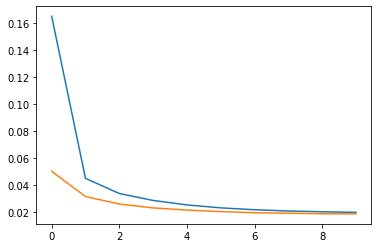

In [11]:
optim = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.BCEWithLogitsLoss(weight = class_weights)
train_losses = []
val_losses = []
waited = 0

min_val_loss = np.inf

for epoch in range(epochs):
    epoch_train_loss = []
    
    for embeddings_batch, labels_batch in batchify_tokens_tags(train_input, train_output, batch_size):
        optim.zero_grad()
        out = model.forward(embeddings_batch)
        
        # logits_final, labels_final = outputs_keep_useful_part(out.logits, labels_batch, useful_pos_batch)
        loss = criterion(out, labels_batch)
        loss.backward()
        optim.step()
        epoch_train_loss.append(loss.item())
    
    epoch_train_loss = np.mean(epoch_train_loss)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = compute_loss(model, val_input, val_output, batch_size, criterion)
    
    print(f"Epoch {epoch + 1}: Train loss = {epoch_train_loss}, Val loss = {epoch_val_loss}")
    
    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'saved_models/MOVE_AGENT_ACTS_LSTM.pt')
    
    if len(val_losses) != 0 and val_losses[-1] <= epoch_val_loss:
        waited += 1
        if waited > patience:
                val_losses.append(epoch_val_loss)
                break
    else:
        waited = 0
    
    val_losses.append(epoch_val_loss)

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()


In [12]:
model.load_state_dict(torch.load('saved_models/MOVE_AGENT_ACTS_LSTM.pt'))

predicted_output = predict(model, test_input, batch_size)

acc = accuracy_score(test_output, predicted_output)
report = classification_report(test_output, predicted_output, target_names = mlb.classes_, digits = 3)
print(report)
print(f'acc = {acc}')

                      precision    recall  f1-score   support

        Booking-Book      0.954     0.978     0.966       511
      Booking-Inform      0.541     0.039     0.073       510
      Booking-NoBook      0.757     0.438     0.555       121
     Booking-Request      0.809     0.500     0.618       288
        Hotel-Inform      0.803     0.868     0.834       773
       Hotel-NoOffer      0.000     0.000     0.000        65
     Hotel-Recommend      0.000     0.000     0.000       133
       Hotel-Request      0.652     0.469     0.546       260
        Hotel-Select      0.000     0.000     0.000        78
   Restaurant-Inform      0.768     0.835     0.800       686
  Restaurant-NoOffer      0.000     0.000     0.000       107
Restaurant-Recommend      0.000     0.000     0.000       139
  Restaurant-Request      0.688     0.749     0.717       283
   Restaurant-Select      0.000     0.000     0.000        81
         general-bye      0.000     0.000     0.000        13
       

/home/adrian/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adrian/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adrian/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
